Librerias

In [2]:
import nibabel as nb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LinearSegmentedColormap
from pyrobex.robex import robex
from sklearn.cluster import KMeans
from scipy import sparse, ndimage
import numpy as np

Remosión del craneo

In [3]:
# img_ = nb.load('MRIsamples/analyze_to_nii/10460_T1w.nii.gz')
# stripped, mask = robex(img_)
# nb.save(stripped, 'MRIsamples/robex/10460_T1w_stripped.nii.gz')
# nb.save(mask, 'MRIsamples/robex/10460_T1w_mask.nii.gz')

Creación del sistema lineal

In [4]:
def create_A_x_b(img, c):    
    x = img.reshape((-1, 1))
    b = sparse.csc_array(x.shape)
    A = sparse.identity(x.shape[0], format='lil')
    scale = -c / 4
    i = 1
    
    for f in range(A.shape[0] - 1):
        c1 = f + 1
        c2 = f + img.shape[1]
        
        if i < img.shape[1]:
            A[f, c1] = scale
            A[c1, f] = scale
            
            if c2 < A.shape[0]:
                A[f, c2] = scale
                A[c2, f] = scale
                
            i += 1
        else:
            A[f, c2] = scale
            A[c2, f] = scale
            i = 1
            
    return A,x,b

Metodo lineal

In [5]:
def general_method(A, x, b, Q, maxit):
    I = sparse.identity(A.shape[0], format='csc')
    Q_inv = sparse.linalg.inv(Q)
    new_A = I - Q_inv.dot(A)
    new_b = Q_inv.dot(b)
    i = 0

    while i < maxit:
        x = new_A.dot(x) + new_b        
        i = i + 1

    return x

In [6]:
def jacobi_method(A, x, b, maxit):
    Q_diag = sparse.identity(A.shape[0], format='csc')
    Q_diag.setdiag(A.diagonal())  
    return general_method(A, x, b, Q_diag, maxit)

In [7]:
def gaussseidel_method(A, x, b, maxit):
    Q_tri_inf = sparse.tril(A, 0, format='csc')
    return general_method(A, x, b, Q_tri_inf, maxit)

Metodo no lineal

In [8]:
def newtonRaphson(img, lineal_method, maxiter_nr, maxiter_lm, c):
    A, x, b = create_A_x_b(sparse.csc_array(img), c)
    x_lm = sparse.csc_array(x.shape)
    i = 0
    
    while i < maxiter_nr:
        x_lm = x + x_lm
        delta_x = lineal_method(A, x_lm, b, maxiter_lm)
        x = x - delta_x
        i += 1
    
    return x.toarray()

segmentación

In [9]:
def segmentation_kmeans(img, x, n_clusters_, tol_):
    segs = {
        'probabilityimages': [],
        'segmentation': None
    }
       
    km = KMeans(n_clusters=n_clusters_, tol=tol_).fit(x)
    centers = np.array(km.cluster_centers_, dtype='uint8')
    min_color_pos = np.where(centers == np.amin(centers))[0]

    seg = np.choose(km.labels_, centers)
    seg.shape = img.shape
    segs['segmentation'] = seg
    
    for i in range(n_clusters_):
        labels = km.labels_.copy()
        labels[labels != i] = min_color_pos
        
        seg = np.choose(labels, centers)
        seg.shape = img.shape
        segs['probabilityimages'].append(seg)
        
    return segs

Lectura MRI 

float64
(176, 256, 256)
(176, 256)
(130, 120)


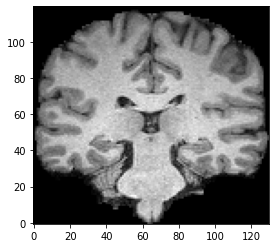

In [36]:
img = nb.load('MRIsamples/robex/10325_T1w_stripped.nii.gz')

img_data = img.get_fdata()
print(img_data.dtype)
print(img_data.shape)

img_slice = img_data[:,130,:]
print(img_slice.shape)

img_zoom = img_slice[22:152, 106:226]
print(img_zoom.shape)

plt.imshow(img_zoom.T, origin='lower', cmap='gray')
plt.show()

Ejecución

In [ ]:
# img_sf = ndimage.gaussian_filter(img_zoom, sigma=0.8)
# plt.imshow(img_sf.T, origin='lower', cmap='gray')
# plt.show()

In [ ]:
for i in range(20, 36, 5):
    for j in np.arange(0.6, 0.8, 0.1).round(1): 
        image_nr_jc = newtonRaphson(img_zoom, jacobi_method, 15, i, j)
        np.save(f'MRIsamples/test/iter/10325/coronal/nr15_jc{i}_c{j}', image_nr_jc)

In [ ]:
# wcss=[]

# for i in range(1,10):
#     km = KMeans(n_clusters=i, tol=1e-4)
#     km.fit(image_nr_jc)
#     wcss.append(km.inertia_)
    
# plt.title('Método del Codo')
# plt.xlabel('No. de clusters')
# plt.ylabel('Inercia')
# plt.grid(True)
# plt.plot(list(range(1, 10)), wcss, marker='o')
# plt.show()

In [ ]:
color_segs = LinearSegmentedColormap.from_list('mycmap', ['black', 'green', 'yellow', 'orange'])
color_segs1 = LinearSegmentedColormap.from_list('mycmap', ['black', 'green'])
color_segs2 = LinearSegmentedColormap.from_list('mycmap', ['black', 'orange'])
color_segs3 = LinearSegmentedColormap.from_list('mycmap', ['black', 'yellow'])

Resultados

In [ ]:
def segmetation(image_nr_lm, img_segs, i, j):

    figure, axis = plt.subplots(ncols = 4, nrows = 2, figsize=(20, 14))

    axis[0, 0].imshow(img_zoom.T, origin='lower', cmap='gray')
    axis[0, 0].set_title("Original")

    image_nr_lm = image_nr_jc.copy()
    image_nr_lm.shape = img_zoom.shape
    axis[0, 1].imshow(image_nr_lm.T, origin='lower', cmap='gray')
    axis[0, 1].set_title(f'nr15_jc{i}_c{j}')

    axis[0, 2].imshow(img_segs['segmentation'].T, origin='lower', cmap=color_segs)

    axis[0, 3].imshow(img_segs['probabilityimages'][0].T, origin='lower', cmap=color_segs1)

    axis[1, 0].imshow(img_segs['probabilityimages'][1].T, origin='lower', cmap=color_segs2)

    axis[1, 1].imshow(img_segs['probabilityimages'][2].T, origin='lower', cmap=color_segs3)

    axis[1, 2].imshow(img_segs['probabilityimages'][3].T, origin='lower', cmap=color_segs3)

    figure.savefig(f'MRIsamples/test/segmetations/10325/coronal/nr15_jc{i}_c{j}.png')
    plt.close(figure)

for i in range(20, 36, 5):
    for j in np.arange(0.6, 0.8, 0.1).round(1): 
            image_nr_jc = np.load(f'MRIsamples/test/iter/10325/coronal/nr15_jc{i}_c{j}.npy')
            img_segs = segmentation_kmeans(img_zoom, image_nr_jc, 4, 1e-4)
            segmetation(image_nr_jc, img_segs, i, j)